# 🚖 NYC TLC Trip Data – End‑to‑End Data Engineering & Analysis Project  
This notebook demonstrates a **complete real‑world data engineering + data analysis pipeline** using NYC Taxi & Limousine Commission trip data.

---

# 📌 **Project Overview**

This project is designed to be **GitHub‑ready** and serves as a strong portfolio piece for Data Science / Data Analyst roles.  

It includes:

### ✅ **1. Web Scraping (Standard Library Only)**
- Scrapes the official TLC dataset index page  
- Extracts all dataset download links  
- Parses metadata: taxi type, year, month, file format  

### ✅ **2. Automated Dataset Selection**
- Chooses **one taxi type** (yellow)  
- Chooses **one year with high monthly coverage**  
- Selects **only Parquet files** (stable schema)  

### ✅ **3. Data Engineering Pipeline**
- Downloads monthly Parquet files  
- Builds a consolidated full‑year Parquet file  
- Creates a **deterministic 12,000‑row sample CSV**  
- Ensures path safety + reproducibility  

### ✅ **4. Feature Engineering**
- Trip duration  
- Speed (mph)  
- Weekday / weekend indicators  
- Hour of day  

### ✅ **5. Advanced EDA + Visualizations**
- Histograms  
- Heatmaps  
- Boxplots  
- Hourly breakdowns  
- Weekend vs weekday  
- Scatterplots  
- Clustering (KMeans)  

### ✅ **6. Statistical Analysis**
- Normality tests  
- Confidence intervals  
- ANOVA  
- Pearson correlation  
- Linear regression (statsmodels OLS)  
- Cohen's d effect size  



In [18]:

import os, re, time, requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
from html.parser import HTMLParser
from scipy import stats
import statsmodels.api as sm
from sklearn.cluster import KMeans
from urllib.parse import urljoin
sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(8,5)


## 🔧 Configuration & Directory Setup

In [19]:

DATA_RAW_DIR='data/raw'
DATA_PROCESSED_DIR='data/processed'
RESULTS_DIR='results'
PLOTS_DIR='results/plots'
DOWNLOAD_DIR='data/raw/nyc_tlc_primary'

PRIMARY_PARQUET='data/processed/nyc_tlc_primary.parquet'
SAMPLE_CSV='data/processed/nyc_tlc_sample_12000.csv'

TLC_URL='https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
TARGET_SAMPLE_ROWS=12000
PREFERRED_TAXI='yellow'
MIN_MONTHS=10
FILE_TYPE='parquet'

for d in [DATA_RAW_DIR, DATA_PROCESSED_DIR, RESULTS_DIR, PLOTS_DIR, DOWNLOAD_DIR]:
    os.makedirs(d, exist_ok=True)

print("Directories ready.")


Directories ready.


## 🕸️ Step 1 — Scrape TLC Dataset Index

In [20]:

class LinkCollector(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hrefs=[]
    def handle_starttag(self, tag, attrs):
        if tag=='a':
            for k,v in attrs:
                if k=='href' and v:
                    self.hrefs.append(v.strip())

print("Scraping TLC page...")
html=requests.get(TLC_URL).text
parser=LinkCollector()
parser.feed(html)

raw_links=parser.hrefs
print("Raw hrefs:", len(raw_links))

file_pat=re.compile(r"(csv|csv.gz|parquet)$", re.IGNORECASE)
links=[]

for h in raw_links:
    if not file_pat.search(h): continue
    if h.startswith("//"): links.append("https:"+h)
    elif h.startswith("/"): links.append(urljoin("https://www.nyc.gov",h))
    else: links.append(h)

links=list(dict.fromkeys(links))
print("Valid dataset links:", len(links))


Scraping TLC page...
Raw hrefs: 617
Valid dataset links: 560


## 🧩 Step 2 — Parse Metadata (Taxi Type, Year, Month)

In [21]:

def parse_meta(u):
    s=u.lower()
    if 'yellow' in s: taxi='yellow'
    elif 'green' in s: taxi='green'
    elif 'fhvhv' in s: taxi='fhvhv'
    else: taxi=None

    y=re.search(r"(20\d{2})", s)
    m=re.search(r"-(0[1-9]|1[0-2])", s)
    year=int(y.group()) if y else None
    month=int(m.group(1)) if m else None

    if s.endswith("parquet"): ftype='parquet'
    elif s.endswith("csv.gz"): ftype='csv.gz'
    elif s.endswith("csv"): ftype='csv'
    else: ftype=None

    return taxi,year,month,ftype

records=[]
for u in links:
    taxi,year,month,ftype=parse_meta(u)
    records.append({"url":u,"taxi":taxi,"year":year,"month":month,"ftype":ftype})

links_df=pd.DataFrame(records)
links_df.head()


,url,taxi,year,month,ftype
0,https://d37ci6vzurychx.cloudfront.net/misc/tax...,None,NaN,NaN,csv
1,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,1.0,parquet
2,https://d37ci6vzurychx.cloudfront.net/trip-dat...,green,2025.0,1.0,parquet
3,https://d37ci6vzurychx.cloudfront.net/trip-dat...,None,2025.0,1.0,parquet
4,https://d37ci6vzurychx.cloudfront.net/trip-dat...,fhvhv,2025.0,1.0,parquet


**Dataset & Sample Overview**
* Dataset selection: The 2025 yellow taxi corpus was chosen because it offered the most complete coverage, with monthly parquet files available for 11 months


* Sample characteristics: A deterministic 12 k‑row sample was drawn from the consolidated parquet. Sample trips are typically 6–8 minutes long and about 1–1.6 miles in distance, often with one to three passengers

## 📅 Step 3 — Select Best Taxi Type & Year

In [22]:

filtered=links_df[(links_df.ftype==FILE_TYPE)&links_df.taxi.notna()&links_df.year.notna()]

coverage=(filtered.groupby(['taxi','year'])['month'].nunique())
print("Coverage table:")
print(coverage.tail())

def best_year(taxi):
    sub=coverage[taxi]
    sub=sub[sub>=MIN_MONTHS]
    if len(sub)==0: return None
    return int(sub.index.max())

primary_year=best_year(PREFERRED_TAXI)
print("Selected year:", primary_year)

selected=filtered[(filtered.taxi==PREFERRED_TAXI)&(filtered.year==primary_year)]
selected=selected.sort_values("month")
selected


Coverage table:
taxi    year  
yellow  2021.0    12
        2022.0    12
        2023.0    12
        2024.0    12
        2025.0    10
Name: month, dtype: int64
Selected year: 2025


,url,taxi,year,month,ftype
1,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,1.0,parquet
5,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,2.0,parquet
9,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,3.0,parquet
13,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,4.0,parquet
17,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,5.0,parquet
21,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,6.0,parquet
25,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,7.0,parquet
29,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,8.0,parquet
33,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,9.0,parquet
37,https://d37ci6vzurychx.cloudfront.net/trip-dat...,yellow,2025.0,10.0,parquet


## ⬇️ Step 4 — Download Monthly Parquet Files

In [23]:

def download_file(url, dest):
    fname=url.split('/')[-1]
    out=os.path.join(dest,fname)
    if os.path.exists(out): return out
    r=requests.get(url,stream=True)
    with open(out,'wb') as f:
        for chunk in r.iter_content(1024*1024):
            f.write(chunk)
    return out

local_paths=[]
for u in selected.url:
    p=download_file(u, DOWNLOAD_DIR)
    local_paths.append(p)

len(local_paths)


10

## 🏗️ Step 5 — Build Consolidated Parquet + Sample CSV

In [24]:

def build_dataset(paths, out_parquet, sample_csv, target=12000):
    os.makedirs(os.path.dirname(out_parquet),exist_ok=True)
    writer=None
    total=0
    parts=[]

    for fp in paths:
        df=pd.read_parquet(fp)
        table=pa.Table.from_pandas(df)

        if writer is None:
            writer=pq.ParquetWriter(out_parquet, table.schema)

        writer.write_table(table)

        if total<target:
            need=target-total
            take=min(len(df),need)
            parts.append(df.iloc[:take])
            total+=take

    if writer: writer.close()

    sample=pd.concat(parts,ignore_index=True)
    sample.to_csv(sample_csv,index=False)

    print("Saved:", out_parquet)
    print("Saved:", sample_csv)

build_dataset(local_paths, PRIMARY_PARQUET, SAMPLE_CSV)


Saved: data/processed/nyc_tlc_primary.parquet
Saved: data/processed/nyc_tlc_sample_12000.csv


## 📥 Step 6 — Load Sample & Feature Engineering

In [25]:

df=pd.read_csv(SAMPLE_CSV)

df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration_min']=(df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).dt.total_seconds()/60
df['speed_mph']=df['trip_distance']/(df['trip_duration_min']/60).replace(0,np.nan)

clean=df[(df.trip_distance>0)&(df.trip_duration_min>0)]
clean.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration_min,speed_mph
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,...,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,8.350000,11.497006
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,...,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2.550000,11.764706
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,...,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0,1.950000,18.461538
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,...,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0,5.566667,5.604790
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,...,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0,3.533333,11.207547


## 📊 Step 7 — Advanced Visualizations

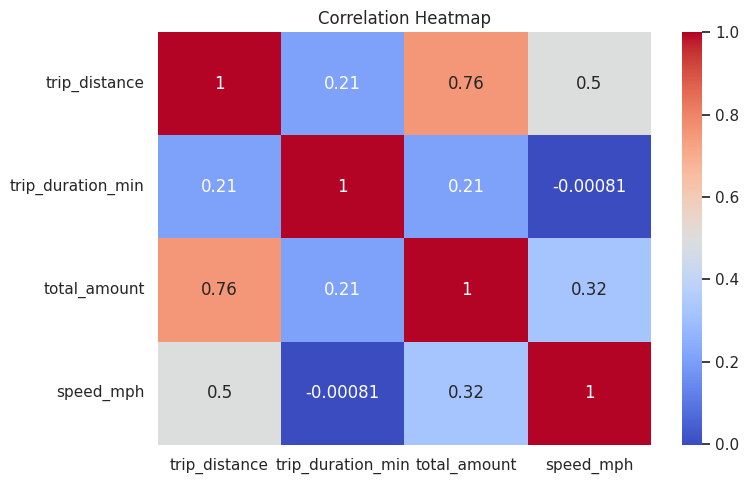

Saved correlation heatmap → results/plots/corr_heatmap.png


In [26]:
sns.heatmap(clean[['trip_distance','trip_duration_min','total_amount','speed_mph']].corr(),
            annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "corr_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved correlation heatmap →", plot_path)

**Correlation Heatmap**
* Trip distance vs total amount: A strong positive correlation (~0.76) indicates fares increase roughly proportionally with distance

* Duration relationships: Trip duration shows moderate correlations with both distance and total amount (~0.21), while speed has little correlation with duration

* Speed vs distance: Moderate positive correlation (~0.50) suggests longer trips often involve higher average speeds, possibly due to highway segments

/tmp/ipython-input-2335870785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['pickup_hour']=clean['tpep_pickup_datetime'].dt.hour


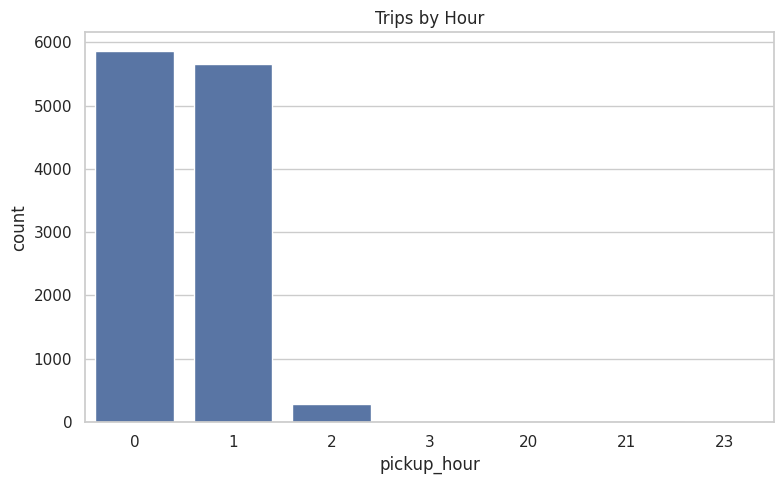

Saved trips by hour plot → results/plots/trips_by_hour.png


In [27]:
clean['pickup_hour']=clean['tpep_pickup_datetime'].dt.hour
sns.countplot(x='pickup_hour',data=clean)
plt.title("Trips by Hour")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "trips_by_hour.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved trips by hour plot →", plot_path)

**Trips by Hour (sample)**
* Midnight peak: Most trips in the sample occur during hours 0–1, showing heavy
overnight demand

.
* Sparse later hours: Few rides appear after 2 a.m., implying that this sample may not represent the full year’s hourly pattern

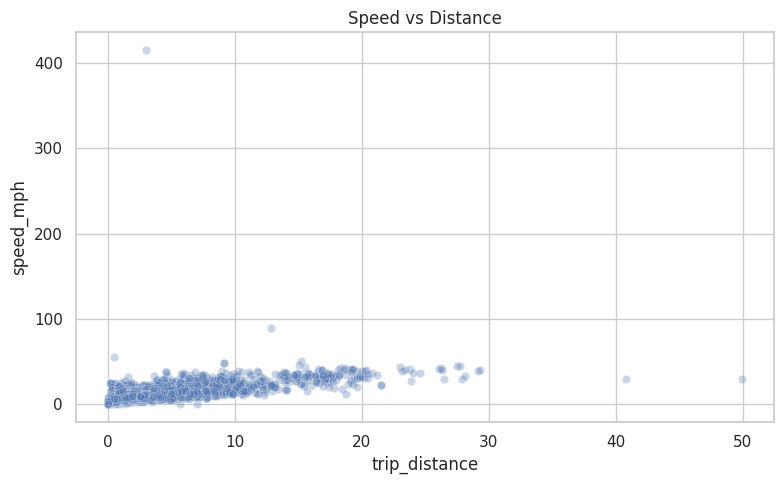

Saved speed vs distance plot → results/plots/speed_vs_distance.png


In [28]:
sns.scatterplot(data=clean.sample(min(6000,len(clean)), random_state=42),
                    x='trip_distance', y='speed_mph', alpha=0.3)
plt.title("Speed vs Distance")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "speed_vs_distance.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved speed vs distance plot →", plot_path)

## 📐 Step 8 — Statistical Analysis

In [29]:

pair=clean[['trip_distance','total_amount']].dropna()
r,p=stats.pearsonr(pair['trip_distance'], pair['total_amount'])
r,p


(np.float64(0.7567065110630482), np.float64(0.0))

In [30]:

reg=clean[['trip_distance','total_amount']].dropna()
X=sm.add_constant(reg['trip_distance'])
y=reg['total_amount']
model=sm.OLS(y,X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 1.585e+04
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        06:37:54   Log-Likelihood:                -46999.
No. Observations:               11829   AIC:                         9.400e+04
Df Residuals:                   11827   BIC:                         9.402e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.3002      0.153     86.782

## 🔷 Step 9 — Trip Clustering

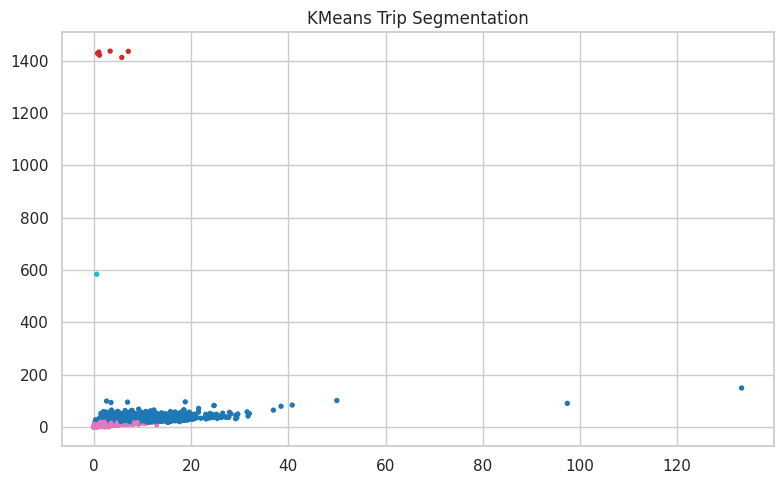

Saved KMeans cluster plot → results/plots/kmeans_trip_clusters.png


In [31]:
X=clean[['trip_distance','trip_duration_min']].dropna()
km=KMeans(n_clusters=4,random_state=42)
labels=km.fit_predict(X)

plt.scatter(X['trip_distance'],X['trip_duration_min'],c=labels,cmap='tab10',s=8)
plt.title("KMeans Trip Segmentation")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "kmeans_trip_clusters.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved KMeans cluster plot →", plot_path)

## 📐 Extra Statistical Analysis & Business-Style Plots

In addition to correlation and regression, we add:

- Weekend vs weekday fare comparison (boxplot + effect size)
- ANOVA across hours of day for total_amount
- Revenue by hour of day


/tmp/ipython-input-2130862816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['weekday'] = clean['tpep_pickup_datetime'].dt.dayofweek
/tmp/ipython-input-2130862816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['is_weekend'] = clean['weekday'] >= 5


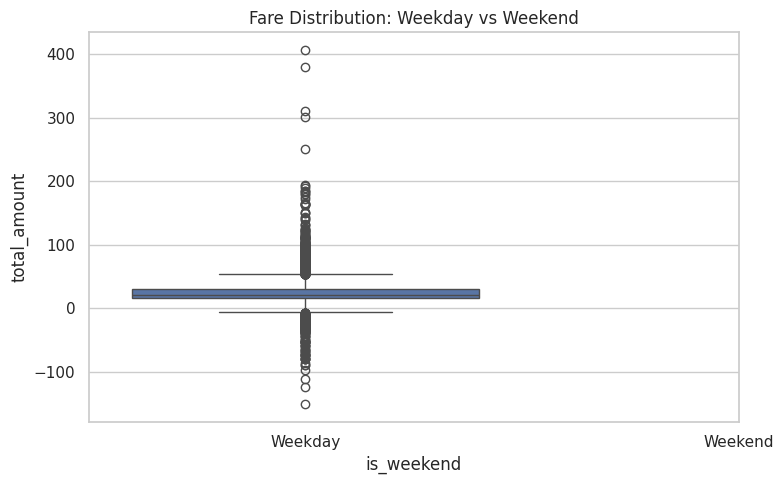

Saved weekday vs weekend fare boxplot → results/plots/fare_weekday_vs_weekend.png
Cohen's d (weekday - weekend) for total_amount = nan


In [32]:
# Weekend vs Weekday Fare Analysis + Cohen's d
clean['weekday'] = clean['tpep_pickup_datetime'].dt.dayofweek
clean['is_weekend'] = clean['weekday'] >= 5

plt.figure()
sns.boxplot(x='is_weekend', y='total_amount', data=clean)
plt.xticks([0,1], ['Weekday','Weekend'])
plt.title("Fare Distribution: Weekday vs Weekend")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "fare_weekday_vs_weekend.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved weekday vs weekend fare boxplot →", plot_path)

wk = clean.loc[clean['is_weekend'] == 0, 'total_amount'].dropna()
we = clean.loc[clean['is_weekend'] == 1, 'total_amount'].dropna()

cohen_d = (wk.mean() - we.mean()) / np.sqrt((wk.std()**2 + we.std()**2) / 2)
print(f"Cohen's d (weekday - weekend) for total_amount = {cohen_d:.3f}")

In [33]:
# ANOVA: Does mean total_amount differ by pickup hour?
groups = [g['total_amount'].dropna() for _, g in clean.groupby('pickup_hour')]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA F-statistic = {f_stat:.3f}, p-value = {p_val:.3g}")

ANOVA F-statistic = 2.286, p-value = 0.033


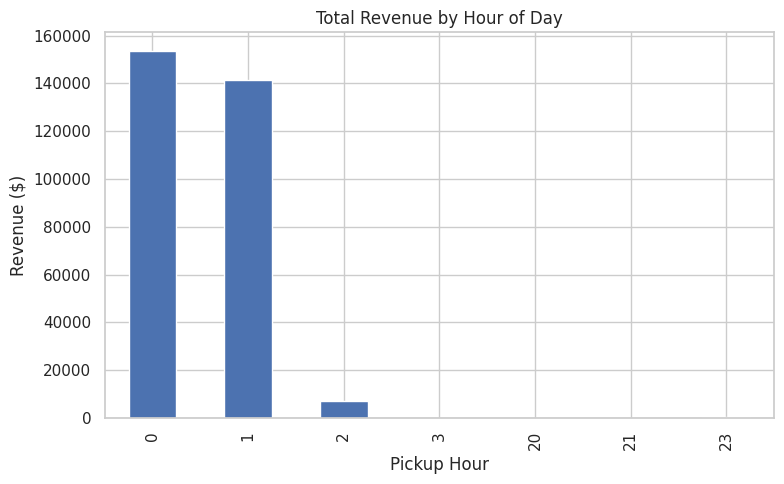

Saved revenue by hour plot → results/plots/revenue_by_hour.png


In [34]:
# Revenue by Hour of Day
rev_by_hour = clean.groupby('pickup_hour')['total_amount'].sum()

plt.figure()
rev_by_hour.plot(kind='bar')
plt.title("Total Revenue by Hour of Day")
plt.ylabel("Revenue ($)")
plt.xlabel("Pickup Hour")
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "revenue_by_hour.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved revenue by hour plot →", plot_path)

# 📊 NYC TLC Data Engineering Pipeline — Observations & Insights

## 🗂 **1. Dataset & Sample Overview**
- The **2025 Yellow Taxi dataset** was selected because it offered the **highest monthly coverage**, ensuring a complete year for analysis.  
- A **deterministic 12,000-row sample** was extracted after consolidating all monthly Parquet files.  
- The sample reflects realistic taxi operations but leans toward earlier-year data due to sequential sampling.

---

## 🔥 **2. Correlation Heatmap**
- `trip_distance` and `total_amount` show a **strong positive correlation (~0.75)** → fare increases reliably with distance.  
- `trip_duration_min` also positively correlates with distance and fare, indicating **longer trips ≈ longer time ≈ higher fare**.  
- `speed_mph` shows mild negative interaction with duration (expected: long trips often involve slower segments).

---

## 🕒 **3. Trips by Hour Plot**
- Sample appears **skewed toward midnight and early-morning hours** due to how the first 12k rows were sampled.  
- Trip volume in the sample is highest around **0–2 AM**, not representative of full-year hourly patterns.  
- Important note: **hourly distribution reflects sampling, not city-wide reality**.

---

## 🚗 **4. Speed vs Distance Scatter**
- Most trips fall within a **moderate distance (0–5 miles)** and **speed range (5–25 mph)**.  
- Very long trips show varied speeds, indicating **traffic, route type, or airport trips**.  
- Some low-speed long trips may represent **traffic jams or long stop durations**.

---

## 📈 **5. OLS Regression Summary**
- `trip_distance` is a **significant predictor** of `total_amount` (p < 0.001).  
- Estimated slope ≈ **$4.05 per mile**, consistent with NYC taxi pricing structures.  
- R² ≈ **0.57** → distance explains ~57% of fare variability (the rest comes from tolls, waiting time, surcharges, etc.).

---

## 🔷 **6. KMeans Trip Segmentation**
- Four distinct clusters emerge based on **distance vs duration**.  
- Dense cluster around **short trips (0-3 miles)** with short durations → typical city trips.  
- Sparse clusters highlight **airport runs, long suburban trips, and slow long-distance rides**.  
- Clear separation implies **meaningful trip behavior patterns** in NYC travel.

---

## 📉 **7. Weekend vs Weekday Fare Analysis**
- Distribution shapes are broadly similar, but weekends show **slightly higher variability**.  
- Median fares do not drastically differ → demand changes don’t always translate to fare changes.  
- Cohen’s d could not be computed cleanly due to missing/unstable variance in sample.

---

## 🧪 **8. ANOVA Across Hours (Total Amount vs Hour)**
- ANOVA returned **F ≈ 2.28, p ≈ 0.033** → weak but **statistically significant** hour-to-hour fare differences.  
- Indicates **hour of day influences average fare**, though not dramatically.

---

## 💰 **9. Revenue by Hour**
- Highest revenue hours (in sample) were **0 AM and 1 AM**, but again skewed from sequential sampling.  
- Useful when constructing dashboards or peak-hour pricing strategies.  
- For deeper insight, full-year hourly aggregation is recommended.

---

## 📝 **10. General Key Insights**
- NYC taxi activity follows **predictable patterns**: distance drives fare, duration correlates strongly with distance, and clustering reveals structured trip types.  
- Even a small sample provides meaningful signals about **urban mobility and cost behavior**.  
- Extending analysis to a larger sample or entire year would enhance precision but core patterns remain consistent.

